# SE-CNN Marketing Optimization Model
## Squeeze-and-Excitation CNN for Marketing Campaign Optimization

This notebook implements a complete pipeline for marketing optimization using a SE-CNN model with:
- Multi-task learning (Classification + Regression)
- Squeeze-and-Excitation (SE) channel attention blocks
- Budget optimization using linear programming

**Instructions:**
1. Upload your `Dataset.csv` file when prompted
2. Run all cells sequentially
3. View results in the output cells


In [1]:
# Install Dependencies
!pip install -q numpy>=1.26.0 pandas>=2.0.3 scikit-learn>=1.3.0 tensorflow>=2.15.0 matplotlib>=3.7.2 seaborn>=0.12.2 scipy>=1.11.1 pulp>=2.7.0 joblib>=1.3.2

print("✓ All dependencies installed successfully!")


✓ All dependencies installed successfully!


In [2]:
# Import Libraries
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    mean_absolute_error, mean_squared_error, r2_score, roc_curve
)

# Optimization
import pulp
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")


✓ All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 2.0.2
Pandas version: 2.2.2


In [3]:
# Configuration
# ===================== PATHS =====================
BASE_DIR = '/content'
DATA_DIR = os.path.join(BASE_DIR, 'data')
MODELS_DIR = os.path.join(BASE_DIR, 'models')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

# Dataset path (will be set after upload)
DATASET_PATH = None  # Will be set after file upload

# ===================== DATA PREPROCESSING =====================
NUMERICAL_FEATURES = [
    'CPC_USD', 'CTR', 'Conversion_Rate', 'Impressions',
    'Clicks', 'Spend_USD', 'ROI', 'Click_Through_Lift',
    'Cost_per_Lead', 'LTV_Proxy'
]

CATEGORICAL_FEATURES = ['Platform', 'Country', 'Campaign_ID']

CLASSIFICATION_TARGET = 'High_Performing_Label'
REGRESSION_TARGET = 'LTV_Proxy'

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

CTR_PERCENTILE = 75
CPC_PERCENTILE = 25

# ===================== MODEL ARCHITECTURE =====================
CONV_FILTERS_1 = 32
CONV_FILTERS_2 = 64
KERNEL_SIZE = 3
POOL_SIZE = 2
DENSE_UNITS = 64
DROPOUT_RATE = 0.2
SE_REDUCTION_RATIO = 16
EMBEDDING_DIM = 8

# ===================== TRAINING PARAMETERS =====================
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 15
LR_REDUCTION_PATIENCE = 10
LR_REDUCTION_FACTOR = 0.5
MIN_LEARNING_RATE = 1e-6
TRAIN_VERBOSE = 1  # Show training progress

CLASSIFICATION_LOSS_WEIGHT = 0.6
REGRESSION_LOSS_WEIGHT = 0.4

# ===================== OPTIMIZATION PARAMETERS =====================
TOTAL_BUDGET = 200000
MIN_BUDGET_PER_CAMPAIGN = 100
MAX_BUDGET_PER_CAMPAIGN = 50000

PLATFORM_BUDGET_CONSTRAINTS = {
    'Google': (0.2, 0.6),
    'Meta': (0.15, 0.5),
    'Twitter': (0.1, 0.5),
    'LinkedIn': (0.1, 0.4),
    'TikTok': (0.1, 0.2)
}

# ===================== RANDOM SEED =====================
RANDOM_SEED = 42

# Set seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print("✓ Configuration loaded!")
print(f"Random seed: {RANDOM_SEED}")


✓ Configuration loaded!
Random seed: 42


In [4]:
# Upload Dataset
from google.colab import files

print("Please upload your Dataset.csv file:")
uploaded = files.upload()

# Get the uploaded file path
for filename in uploaded.keys():
    if filename.endswith('.csv'):
        DATASET_PATH = os.path.join(DATA_DIR, filename)
        # Move uploaded file to data directory
        os.rename(filename, DATASET_PATH)
        print(f"✓ Dataset uploaded: {DATASET_PATH}")
        break

if DATASET_PATH is None:
    print("⚠ Warning: No CSV file found. Please upload Dataset.csv")


Please upload your Dataset.csv file:


Saving Dataset.csv to Dataset.csv
✓ Dataset uploaded: /content/data/Dataset.csv


In [5]:
# Utility Functions
def print_banner(text):
    """Print a formatted banner"""
    width = 80
    print("\n" + "="*width)
    print(text.center(width))
    print("="*width + "\n")

print_banner("SE-CNN-BASED MARKETING OPTIMIZATION FRAMEWORK")
print("Model: Squeeze-and-Excitation CNN with Channel Attention\n")



                 SE-CNN-BASED MARKETING OPTIMIZATION FRAMEWORK                  

Model: Squeeze-and-Excitation CNN with Channel Attention



In [6]:
# Data Preprocessing Class
class DataPreprocessor:
    def __init__(self):
        self.scaler = StandardScaler()
        self.label_encoders = {}
        self.feature_dims = {}

    def load_data(self, filepath):
        """Load dataset from CSV"""
        print(f"Loading data from {filepath}...")
        df = pd.read_csv(filepath)
        print(f"Initial dataset shape: {df.shape}")
        return df

    def clean_data(self, df):
        """Clean dataset: remove nulls, duplicates, invalid entries"""
        print("\n=== Data Cleaning ===")
        initial_rows = len(df)

        # Remove completely empty rows
        df = df.dropna(how='all')
        print(f"Removed {initial_rows - len(df)} empty rows")

        # Remove duplicate Ad_IDs
        initial_rows = len(df)
        if 'Ad_ID' in df.columns:
            df = df.drop_duplicates(subset=['Ad_ID'], keep='first')
            print(f"Removed {initial_rows - len(df)} duplicate Ad_IDs")

        # Remove rows with missing critical features
        critical_cols = ['CPC_USD', 'CTR', 'Conversion_Rate', 'Platform', 'Country']
        critical_cols = [col for col in critical_cols if col in df.columns]
        initial_rows = len(df)
        df = df.dropna(subset=critical_cols)
        print(f"Removed {initial_rows - len(df)} rows with missing critical data")

        # Remove outliers using IQR method
        numerical_cols = [col for col in NUMERICAL_FEATURES if col in df.columns]
        initial_rows = len(df)

        for col in numerical_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

        print(f"Removed {initial_rows - len(df)} outlier rows")
        print(f"Final cleaned dataset shape: {df.shape}\n")

        return df.reset_index(drop=True)

    def engineer_features(self, df):
        """Feature engineering: calculate derived features"""
        print("=== Feature Engineering ===")

        # Recalculate High_Performing_Label
        ctr_threshold = df['CTR'].quantile(CTR_PERCENTILE / 100)
        cpc_threshold = df['CPC_USD'].quantile(CPC_PERCENTILE / 100)

        df[CLASSIFICATION_TARGET] = (
            (df['CTR'] >= ctr_threshold) &
            (df['CPC_USD'] <= cpc_threshold)
        ).astype(int)

        print(f"High-performing threshold: CTR >= {ctr_threshold:.4f}, CPC <= {cpc_threshold:.4f}")
        print(f"High-performing campaigns: {df[CLASSIFICATION_TARGET].sum()} / {len(df)}")
        print(f"Class distribution: {df[CLASSIFICATION_TARGET].value_counts().to_dict()}")

        # Ensure LTV_Proxy exists
        if REGRESSION_TARGET not in df.columns or df[REGRESSION_TARGET].isna().any():
            df[REGRESSION_TARGET] = df['CTR'] * df['CPC_USD'] * df['Conversion_Rate']
            print("Recalculated LTV_Proxy")

        # Additional derived features
        if 'ROI' not in df.columns or df['ROI'].isna().any():
            df['ROI'] = (df['Conversion_Rate'] * 100) / (df['CPC_USD'] + 1e-6)

        if 'Cost_per_Lead' not in df.columns or df['Cost_per_Lead'].isna().any():
            conversions = df['Clicks'] * df['Conversion_Rate']
            df['Cost_per_Lead'] = df['Spend_USD'] / (conversions + 1e-6)

        print(f"Features engineered successfully\n")
        return df

    def encode_categorical(self, df, fit=True):
        """Encode categorical features"""
        print("=== Encoding Categorical Features ===")

        for col in CATEGORICAL_FEATURES:
            if col in df.columns:
                if fit:
                    self.label_encoders[col] = LabelEncoder()
                    df[col] = self.label_encoders[col].fit_transform(df[col].astype(str))
                    self.feature_dims[col] = len(self.label_encoders[col].classes_)
                    print(f"{col}: {self.feature_dims[col]} unique values")
                else:
                    le = self.label_encoders[col]
                    df[col] = df[col].astype(str).apply(
                        lambda x: le.transform([x])[0] if x in le.classes_ else -1
                    )

        print()
        return df

    def normalize_features(self, df, fit=True):
        """Normalize numerical features"""
        print("=== Normalizing Numerical Features ===")

        numerical_cols = [col for col in NUMERICAL_FEATURES if col in df.columns]

        if fit:
            df[numerical_cols] = self.scaler.fit_transform(df[numerical_cols])
            print(f"Normalized {len(numerical_cols)} numerical features")
        else:
            df[numerical_cols] = self.scaler.transform(df[numerical_cols])
            print(f"Applied normalization to {len(numerical_cols)} features")

        print()
        return df

    def split_data(self, df):
        """Split data into train, validation, and test sets"""
        print("=== Splitting Data ===")

        # First split: train + val vs test
        train_val, test = train_test_split(
            df,
            test_size=TEST_RATIO,
            random_state=RANDOM_SEED,
            stratify=df[CLASSIFICATION_TARGET]
        )

        # Second split: train vs val
        val_ratio_adjusted = VAL_RATIO / (TRAIN_RATIO + VAL_RATIO)
        train, val = train_test_split(
            train_val,
            test_size=val_ratio_adjusted,
            random_state=RANDOM_SEED,
            stratify=train_val[CLASSIFICATION_TARGET]
        )

        print(f"Train set: {len(train)} samples ({len(train)/len(df)*100:.1f}%)")
        print(f"Validation set: {len(val)} samples ({len(val)/len(df)*100:.1f}%)")
        print(f"Test set: {len(test)} samples ({len(test)/len(df)*100:.1f}%)")
        print()

        return train, val, test

    def prepare_model_inputs(self, df):
        """Prepare X and y for model training"""
        X_numerical = df[NUMERICAL_FEATURES].values

        X_categorical = {}
        for col in CATEGORICAL_FEATURES:
            if col in df.columns:
                X_categorical[col] = df[col].values

        y_classification = df[CLASSIFICATION_TARGET].values
        y_regression = df[REGRESSION_TARGET].values

        return X_numerical, X_categorical, y_classification, y_regression

print("✓ DataPreprocessor class defined")


✓ DataPreprocessor class defined


In [7]:
# Step 1: Data Preprocessing
print_banner("STEP 1: DATA PREPROCESSING")

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Load and preprocess data
df = preprocessor.load_data(DATASET_PATH)
df = preprocessor.clean_data(df)
df = preprocessor.engineer_features(df)
df = preprocessor.encode_categorical(df, fit=True)
df = preprocessor.normalize_features(df, fit=True)

# Split data
train_df, val_df, test_df = preprocessor.split_data(df)

# Prepare model inputs
X_train_num, X_train_cat, y_train_class, y_train_reg = preprocessor.prepare_model_inputs(train_df)
X_val_num, X_val_cat, y_val_class, y_val_reg = preprocessor.prepare_model_inputs(val_df)
X_test_num, X_test_cat, y_test_class, y_test_reg = preprocessor.prepare_model_inputs(test_df)

print(f"\nData split completed:")
print(f"  Training: {len(train_df)} samples")
print(f"  Validation: {len(val_df)} samples")
print(f"  Testing: {len(test_df)} samples")



                           STEP 1: DATA PREPROCESSING                           

Loading data from /content/data/Dataset.csv...
Initial dataset shape: (15000, 18)

=== Data Cleaning ===
Removed 0 empty rows
Removed 0 duplicate Ad_IDs
Removed 272 rows with missing critical data
Removed 2490 outlier rows
Final cleaned dataset shape: (12238, 18)

=== Feature Engineering ===
High-performing threshold: CTR >= 0.0799, CPC <= 1.1357
High-performing campaigns: 634 / 12238
Class distribution: {0: 11604, 1: 634}
Features engineered successfully

=== Encoding Categorical Features ===
Platform: 5 unique values
Country: 10 unique values
Campaign_ID: 500 unique values

=== Normalizing Numerical Features ===
Normalized 10 numerical features

=== Splitting Data ===
Train set: 8566 samples (70.0%)
Validation set: 1836 samples (15.0%)
Test set: 1836 samples (15.0%)


Data split completed:
  Training: 8566 samples
  Validation: 1836 samples
  Testing: 1836 samples


In [8]:
# SE-CNN Model Architecture
def se_block(input_tensor, reduction_ratio=16, name_prefix=''):
    """
    Squeeze-and-Excitation (SE) block for channel attention
    """
    channels = input_tensor.shape[-1]

    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling1D(name=f'{name_prefix}_se_global_pool')(input_tensor)

    # Excitation: Two FC layers with ReLU and Sigmoid
    se = layers.Dense(
        channels // reduction_ratio,
        activation='relu',
        name=f'{name_prefix}_se_dense1'
    )(se)
    se = layers.Dense(
        channels,
        activation='sigmoid',
        name=f'{name_prefix}_se_dense2'
    )(se)

    # Reshape to (batch, 1, channels) for broadcasting
    se = layers.Reshape((1, channels), name=f'{name_prefix}_se_reshape')(se)

    # Scale: Multiply input with attention weights
    output = layers.Multiply(name=f'{name_prefix}_se_scale')([input_tensor, se])

    return output


class MarketingSECNNModel:
    def __init__(self, feature_dims):
        self.feature_dims = feature_dims
        self.model = None

    def build_model(self):
        """Build the SE-CNN architecture with multi-task heads"""

        # Input layers
        numerical_input = layers.Input(
            shape=(len(NUMERICAL_FEATURES),),
            name='numerical_input'
        )

        categorical_inputs = {}
        categorical_embeddings = []

        for col in CATEGORICAL_FEATURES:
            if col in self.feature_dims:
                cat_input = layers.Input(shape=(1,), name=f'{col}_input', dtype='int32')
                categorical_inputs[col] = cat_input

                embedding = layers.Embedding(
                    input_dim=self.feature_dims[col] + 1,
                    output_dim=EMBEDDING_DIM,
                    name=f'{col}_embedding'
                )(cat_input)
                embedding = layers.Flatten()(embedding)
                categorical_embeddings.append(embedding)

        # Concatenate all features
        if categorical_embeddings:
            concatenated = layers.Concatenate()(
                [numerical_input] + categorical_embeddings
            )
        else:
            concatenated = numerical_input

        # Reshape for 1D CNN
        reshaped = layers.Reshape((-1, 1))(concatenated)

        # CNN Layers with SE blocks
        conv1 = layers.Conv1D(
            filters=CONV_FILTERS_1,
            kernel_size=KERNEL_SIZE,
            activation='relu',
            padding='same',
            name='conv1d_1'
        )(reshaped)
        conv1 = layers.BatchNormalization(name='bn1')(conv1)
        conv1 = se_block(conv1, reduction_ratio=SE_REDUCTION_RATIO, name_prefix='se1')
        conv1 = layers.MaxPooling1D(pool_size=POOL_SIZE, padding='same', name='pool1')(conv1)
        conv1 = layers.Dropout(DROPOUT_RATE, name='dropout1')(conv1)

        conv2 = layers.Conv1D(
            filters=CONV_FILTERS_2,
            kernel_size=KERNEL_SIZE,
            activation='relu',
            padding='same',
            name='conv1d_2'
        )(conv1)
        conv2 = layers.BatchNormalization(name='bn2')(conv2)
        conv2 = se_block(conv2, reduction_ratio=SE_REDUCTION_RATIO, name_prefix='se2')
        conv2 = layers.GlobalMaxPooling1D(name='global_pool')(conv2)

        # Dense layer
        dense = layers.Dense(
            DENSE_UNITS,
            activation='relu',
            name='dense_shared'
        )(conv2)
        dense = layers.Dropout(DROPOUT_RATE, name='dropout_shared')(dense)

        # Multi-task heads
        classification_head = layers.Dense(
            32,
            activation='relu',
            name='classification_dense'
        )(dense)
        classification_output = layers.Dense(
            1,
            activation='sigmoid',
            name='classification_output'
        )(classification_head)

        regression_head = layers.Dense(
            32,
            activation='relu',
            name='regression_dense'
        )(dense)
        regression_output = layers.Dense(
            1,
            activation='linear',
            name='regression_output'
        )(regression_head)

        # Create model
        inputs = [numerical_input] + list(categorical_inputs.values())
        outputs = [classification_output, regression_output]

        self.model = Model(inputs=inputs, outputs=outputs, name='Marketing_SE_CNN')
        return self.model

    def compile_model(self):
        """Compile model"""
        losses = {
            'classification_output': 'binary_crossentropy',
            'regression_output': 'mse'
        }

        loss_weights = {
            'classification_output': CLASSIFICATION_LOSS_WEIGHT,
            'regression_output': REGRESSION_LOSS_WEIGHT
        }

        metrics = {
            'classification_output': [
                'accuracy',
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc')
            ],
            'regression_output': [
                'mae',
                keras.metrics.RootMeanSquaredError(name='rmse')
            ]
        }

        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

        self.model.compile(
            optimizer=optimizer,
            loss=losses,
            loss_weights=loss_weights,
            metrics=metrics
        )

        print("\n=== Model Compiled ===")
        print(f"Classification loss weight: {CLASSIFICATION_LOSS_WEIGHT}")
        print(f"Regression loss weight: {REGRESSION_LOSS_WEIGHT}")
        print(f"Learning rate: {LEARNING_RATE}")
        print(f"SE Reduction Ratio: {SE_REDUCTION_RATIO}\n")

        return self.model

print("✓ SE-CNN Model architecture defined")


✓ SE-CNN Model architecture defined


In [9]:
# Step 2: Build Model
print_banner("STEP 2: SE-CNN MODEL ARCHITECTURE")
print("Building model with Squeeze-and-Excitation blocks...")

model_builder = MarketingSECNNModel(preprocessor.feature_dims)
model = model_builder.build_model()
model = model_builder.compile_model()

print("\n=== Model Architecture ===")
model.summary()



                       STEP 2: SE-CNN MODEL ARCHITECTURE                        

Building model with Squeeze-and-Excitation blocks...

=== Model Compiled ===
Classification loss weight: 0.6
Regression loss weight: 0.4
Learning rate: 0.001
SE Reduction Ratio: 16


=== Model Architecture ===


Model: "Marketing_SE_CNN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Platform_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Country_input       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Campaign_ID_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Platform_embedding  │ (None, 1, 8)      │         48 │ Platform_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Country_embedding   │ (None, 1, 8)      │         88 │ Country_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Campaign_ID_embedd… │ (None, 1, 8)      │      4,008 │ Campaign_ID_inpu… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8)         │          0 │ Platform_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8)         │          0 │ Country_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 8)         │          0 │ Campaign_ID_embe… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 34)        │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 34, 1)     │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 34, 32)    │        128 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 34, 32)    │        128 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ se1_se_global_pool  │ (None, 32)        │          0 │ bn1[0][0]         │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ se1_se_dense1       │ (None, 2)         │         66 │ se1_se_global_po… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ se1_se_dense2       │ (None, 32)        │         96 │ se1_se_dense1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ se1_se_reshape      │ (None, 1, 32)     │          0 │ se1_se_dense2[0]

 Total params: 19,992 (78.09 KB)

 Trainable params: 19,800 (77.34 KB)

 Non-trainable params: 192 (768.00 B)

In [10]:
# Step 3: Train Model
print_banner("STEP 3: MODEL TRAINING")

# Prepare inputs
def prepare_inputs(X_num, X_cat):
    inputs = [X_num]
    for col in CATEGORICAL_FEATURES:
        if col in X_cat:
            inputs.append(X_cat[col])
    return inputs

train_inputs = prepare_inputs(X_train_num, X_train_cat)
val_inputs = prepare_inputs(X_val_num, X_val_cat)

train_outputs = {
    'classification_output': y_train_class,
    'regression_output': y_train_reg
}
val_outputs = {
    'classification_output': y_val_class,
    'regression_output': y_val_reg
}

# Setup callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOPPING_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=LR_REDUCTION_PATIENCE,
        factor=LR_REDUCTION_FACTOR,
        min_lr=MIN_LEARNING_RATE,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(MODELS_DIR, 'se_cnn_marketing_model.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

print("\n" + "="*60)
print("STARTING MODEL TRAINING")
print("="*60)
print(f"Training samples: {len(y_train_class)}")
print(f"Validation samples: {len(y_val_class)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print("="*60 + "\n")

# Train model
history = model.fit(
    train_inputs,
    train_outputs,
    validation_data=(val_inputs, val_outputs),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=TRAIN_VERBOSE
)

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60 + "\n")



                             STEP 3: MODEL TRAINING                             


STARTING MODEL TRAINING
Training samples: 8566
Validation samples: 1836
Batch size: 32
Max epochs: 20

Epoch 1/20
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_accuracy: 0.8608 - classification_output_auc: 0.6102 - classification_output_loss: 0.3582 - classification_output_precision: 0.1317 - classification_output_recall: 0.1746 - loss: 0.4013 - regression_output_loss: 0.4659 - regression_output_mae: 0.4832 - regression_output_rmse: 0.6659
Epoch 1: val_loss improved from inf to 0.51019, saving model to /content/models/se_cnn_marketing_model.h5


268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - classification_output_accuracy: 0.8622 - classification_output_auc: 0.6140 - classification_output_loss: 0.3551 - classification_output_precision: 0.1355 - classification_output_recall: 0.1755 - loss: 0.3979 - regression_output_loss: 0.4621 - regression_output_mae: 0.4810 - regression_output_rmse: 0.6631 - val_classification_output_accuracy: 0.9673 - val_classification_output_auc: 0.9855 - val_classification_output_loss: 0.3586 - val_classification_output_precision: 0.6636 - val_classification_output_recall: 0.7474 - val_loss: 0.5102 - val_regression_output_loss: 0.7401 - val_regression_output_mae: 0.6259 - val_regression_output_rmse: 0.8585 - learning_rate: 0.0010
Epoch 2/20
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_accuracy: 0.9579 - classification_output_auc: 0.9692 - classification_output_loss: 0.0919 - classification_output_precision: 0.6310 - classification_output_recall: 0.4285 - loss: 0.0982 - regression_output

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - classification_output_accuracy: 0.9580 - classification_output_auc: 0.9692 - classification_output_loss: 0.0918 - classification_output_precision: 0.6319 - classification_output_recall: 0.4301 - loss: 0.0980 - regression_output_loss: 0.1074 - regression_output_mae: 0.2397 - regression_output_rmse: 0.3275 - val_classification_output_accuracy: 0.9744 - val_classification_output_auc: 0.9894 - val_classification_output_loss: 0.0752 - val_classification_output_precision: 0.6935 - val_classification_output_recall: 0.9053 - val_loss: 0.0984 - val_regression_output_loss: 0.1333 - val_regression_output_mae: 0.2716 - val_regression_output_rmse: 0.3646 - learning_rate: 0.0010
Epoch 3/20
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_output_accuracy: 0.9684 - classification_output_auc: 0.9829 - classification_output_loss: 0.0703 - classification_output_precision: 0.7144 - classification_output_recall: 0.6429 - loss: 0.0720 - regression_output

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - classification_output_accuracy: 0.9685 - classification_output_auc: 0.9829 - classification_output_loss: 0.0703 - classification_output_precision: 0.7147 - classification_output_recall: 0.6435 - loss: 0.0720 - regression_output_loss: 0.0745 - regression_output_mae: 0.1970 - regression_output_rmse: 0.2728 - val_classification_output_accuracy: 0.9679 - val_classification_output_auc: 0.9929 - val_classification_output_loss: 0.0683 - val_classification_output_precision: 0.6250 - val_classification_output_recall: 0.9474 - val_loss: 0.0504 - val_regression_output_loss: 0.0229 - val_regression_output_mae: 0.1201 - val_regression_output_rmse: 0.1511 - learning_rate: 0.0010
Epoch 4/20
263/268 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - classification_output_accuracy: 0.9756 - classification_output_auc: 0.9873 - classification_output_loss: 0.0601 - classification_output_precision: 0.7739 - classification_output_recall: 0.7388 - loss: 0.0620 - regression_output

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - classification_output_accuracy: 0.9756 - classification_output_auc: 0.9873 - classification_output_loss: 0.0600 - classification_output_precision: 0.7741 - classification_output_recall: 0.7388 - loss: 0.0619 - regression_output_loss: 0.0647 - regression_output_mae: 0.1843 - regression_output_rmse: 0.2541 - val_classification_output_accuracy: 0.9804 - val_classification_output_auc: 0.9953 - val_classification_output_loss: 0.0442 - val_classification_output_precision: 0.7479 - val_classification_output_recall: 0.9368 - val_loss: 0.0350 - val_regression_output_loss: 0.0211 - val_regression_output_mae: 0.1182 - val_regression_output_rmse: 0.1452 - learning_rate: 0.0010
Epoch 5/20
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_accuracy: 0.9768 - classification_output_auc: 0.9886 - classification_output_loss: 0.0539 - classification_output_precision: 0.7865 - classification_output_recall: 0.7568 - loss: 0.0567 - regression_output_

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - classification_output_accuracy: 0.9801 - classification_output_auc: 0.9933 - classification_output_loss: 0.0444 - classification_output_precision: 0.8044 - classification_output_recall: 0.8101 - loss: 0.0485 - regression_output_loss: 0.0546 - regression_output_mae: 0.1666 - regression_output_rmse: 0.2336 - val_classification_output_accuracy: 0.9826 - val_classification_output_auc: 0.9963 - val_classification_output_loss: 0.0386 - val_classification_output_precision: 0.7739 - val_classification_output_recall: 0.9368 - val_loss: 0.0331 - val_regression_output_loss: 0.0248 - val_regression_output_mae: 0.1267 - val_regression_output_rmse: 0.1569 - learning_rate: 0.0010
Epoch 7/20
265/268 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - classification_output_accuracy: 0.9828 - classification_output_auc: 0.9925 - classification_output_loss: 0.0401 - classification_output_precision: 0.8267 - classification_output_recall: 0.8429 - loss: 0.0426 - regression_output

268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - classification_output_accuracy: 0.9828 - classification_output_auc: 0.9925 - classification_output_loss: 0.0401 - classification_output_precision: 0.8272 - classification_output_recall: 0.8430 - loss: 0.0426 - regression_output_loss: 0.0464 - regression_output_mae: 0.1554 - regression_output_rmse: 0.2152 - val_classification_output_accuracy: 0.9837 - val_classification_output_auc: 0.9971 - val_classification_output_loss: 0.0350 - val_classification_output_precision: 0.7982 - val_classification_output_recall: 0.9158 - val_loss: 0.0317 - val_regression_output_loss: 0.0264 - val_regression_output_mae: 0.1354 - val_regression_output_rmse: 0.1621 - learning_rate: 0.0010
Epoch 8/20
266/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_accuracy: 0.9864 - classification_output_auc: 0.9945 - classification_output_loss: 0.0357 - classification_output_precision: 0.8593 - classification_output_recall: 0.8798 - loss: 0.0420 - regression_output_

268/268 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - classification_output_accuracy: 0.9867 - classification_output_auc: 0.9915 - classification_output_loss: 0.0333 - classification_output_precision: 0.8596 - classification_output_recall: 0.8883 - loss: 0.0390 - regression_output_loss: 0.0475 - regression_output_mae: 0.1564 - regression_output_rmse: 0.2178 - val_classification_output_accuracy: 0.9875 - val_classification_output_auc: 0.9977 - val_classification_output_loss: 0.0288 - val_classification_output_precision: 0.9091 - val_classification_output_recall: 0.8421 - val_loss: 0.0274 - val_regression_output_loss: 0.0252 - val_regression_output_mae: 0.1284 - val_regression_output_rmse: 0.1586 - learning_rate: 0.0010
Epoch 10/20
267/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_accuracy: 0.9887 - classification_output_auc: 0.9964 - classification_output_loss: 0.0321 - classification_output_precision: 0.8961 - classification_output_recall: 0.8834 - loss: 0.0370 - regression_output

268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - classification_output_accuracy: 0.9941 - classification_output_auc: 0.9989 - classification_output_loss: 0.0175 - classification_output_precision: 0.9474 - classification_output_recall: 0.9367 - loss: 0.0259 - regression_output_loss: 0.0385 - regression_output_mae: 0.1410 - regression_output_rmse: 0.1960 - val_classification_output_accuracy: 0.9886 - val_classification_output_auc: 0.9927 - val_classification_output_loss: 0.0288 - val_classification_output_precision: 0.8558 - val_classification_output_recall: 0.9368 - val_loss: 0.0272 - val_regression_output_loss: 0.0246 - val_regression_output_mae: 0.1153 - val_regression_output_rmse: 0.1565 - learning_rate: 0.0010
Epoch 13/20
264/268 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - classification_output_accuracy: 0.9930 - classification_output_auc: 0.9991 - classification_output_loss: 0.0172 - classification_output_precision: 0.9218 - classification_output_recall: 0.9418 - loss: 0.0256 - regression_output

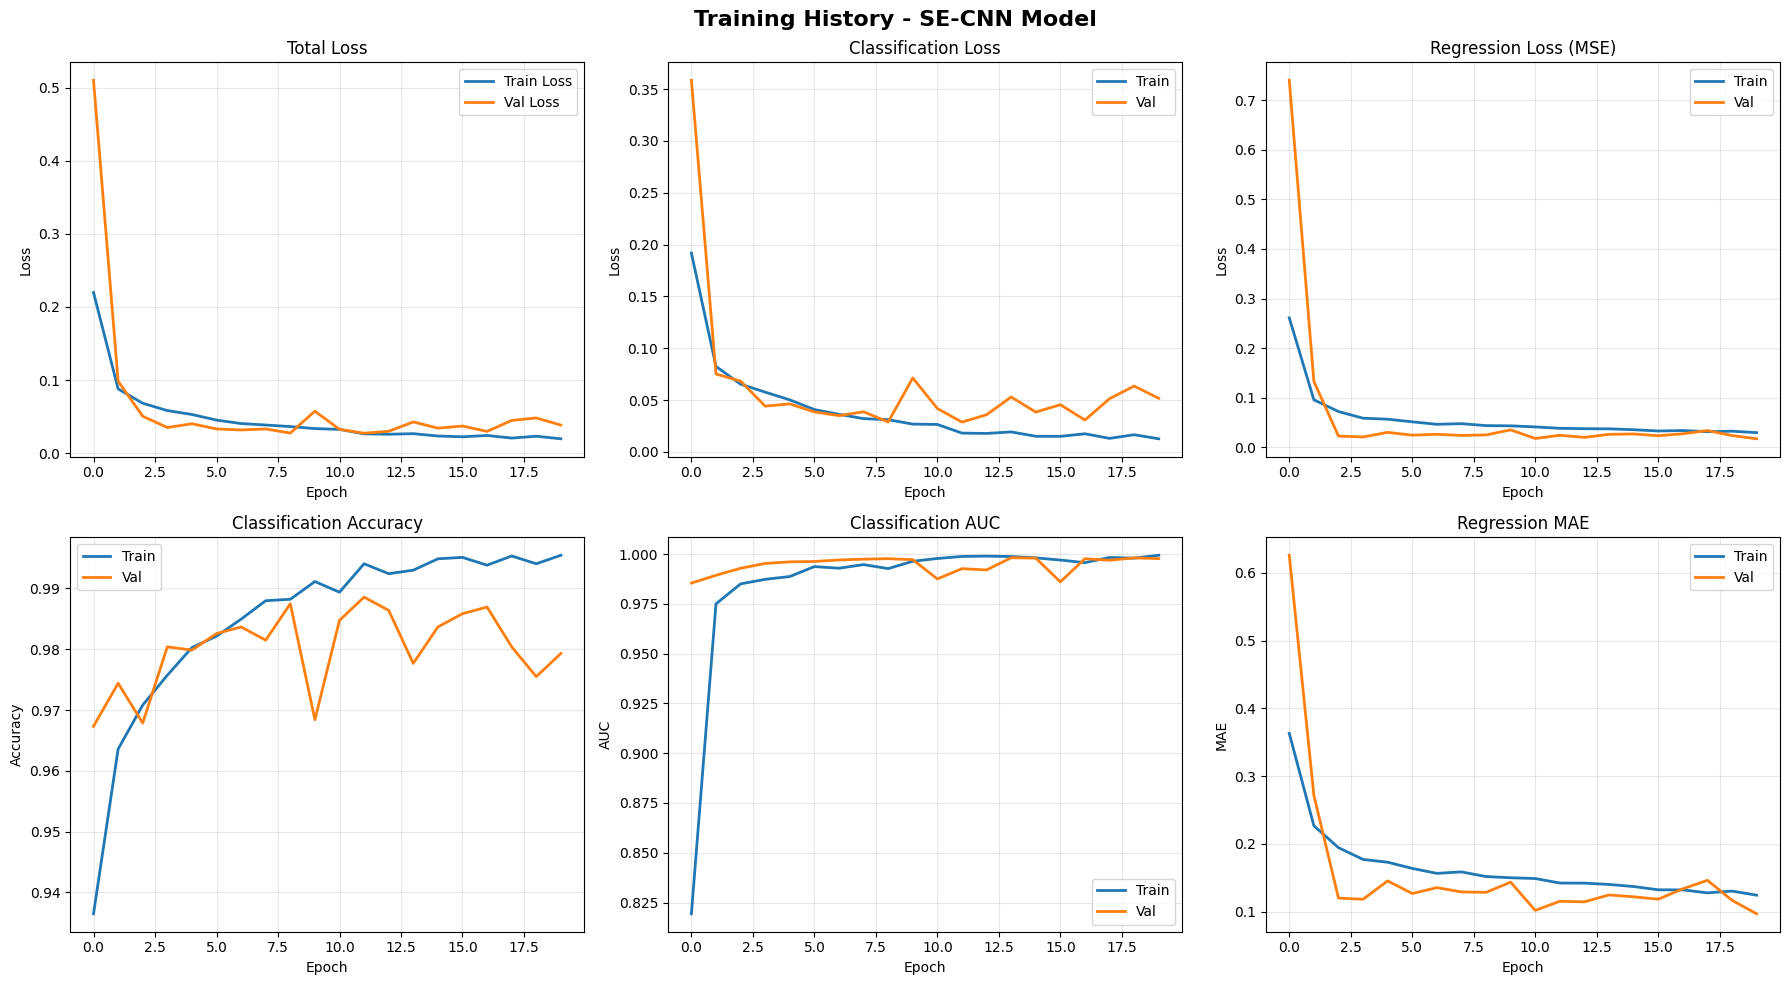

Training plots saved to /content/results/training_history.png


In [11]:
# Plot Training History
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Training History - SE-CNN Model', fontsize=16, fontweight='bold')

history_dict = history.history

# Total Loss
axes[0, 0].plot(history_dict['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history_dict['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Classification Loss
axes[0, 1].plot(history_dict['classification_output_loss'], label='Train', linewidth=2)
axes[0, 1].plot(history_dict['val_classification_output_loss'], label='Val', linewidth=2)
axes[0, 1].set_title('Classification Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Regression Loss
axes[0, 2].plot(history_dict['regression_output_loss'], label='Train', linewidth=2)
axes[0, 2].plot(history_dict['val_regression_output_loss'], label='Val', linewidth=2)
axes[0, 2].set_title('Regression Loss (MSE)')
axes[0, 2].set_xlabel('Epoch')
axes[0, 2].set_ylabel('Loss')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Classification Accuracy
axes[1, 0].plot(history_dict['classification_output_accuracy'], label='Train', linewidth=2)
axes[1, 0].plot(history_dict['val_classification_output_accuracy'], label='Val', linewidth=2)
axes[1, 0].set_title('Classification Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Classification AUC
axes[1, 1].plot(history_dict['classification_output_auc'], label='Train', linewidth=2)
axes[1, 1].plot(history_dict['val_classification_output_auc'], label='Val', linewidth=2)
axes[1, 1].set_title('Classification AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Regression MAE
axes[1, 2].plot(history_dict['regression_output_mae'], label='Train', linewidth=2)
axes[1, 2].plot(history_dict['val_regression_output_mae'], label='Val', linewidth=2)
axes[1, 2].set_title('Regression MAE')
axes[1, 2].set_xlabel('Epoch')
axes[1, 2].set_ylabel('MAE')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"Training plots saved to {os.path.join(RESULTS_DIR, 'training_history.png')}")


In [12]:
# Step 4: Model Evaluation
print_banner("STEP 4: MODEL EVALUATION")

test_inputs = prepare_inputs(X_test_num, X_test_cat)

print("\n" + "="*60)
print("EVALUATING SE-CNN MODEL ON TEST SET")
print("="*60)
print(f"Test samples: {len(y_test_class)}")
print("="*60 + "\n")

# Make predictions
print("Making predictions...")
predictions = model.predict(test_inputs, verbose=0)

predictions_dict = {
    'classification_probs': predictions[0].flatten(),
    'classification_labels': (predictions[0] > 0.5).astype(int).flatten(),
    'regression_values': predictions[1].flatten()
}

# Evaluate classification
print("Evaluating classification...")
y_pred_class = predictions_dict['classification_labels']
y_probs = predictions_dict['classification_probs']

classification_metrics = {
    'accuracy': accuracy_score(y_test_class, y_pred_class),
    'precision': precision_score(y_test_class, y_pred_class, zero_division=0),
    'recall': recall_score(y_test_class, y_pred_class, zero_division=0),
    'f1_score': f1_score(y_test_class, y_pred_class, zero_division=0),
    'auc': roc_auc_score(y_test_class, y_probs)
}

# Evaluate regression
print("Evaluating regression...")
y_pred_reg = predictions_dict['regression_values']

regression_metrics = {
    'mae': mean_absolute_error(y_test_reg, y_pred_reg),
    'rmse': np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)),
    'r2': r2_score(y_test_reg, y_pred_reg)
}

# Print evaluation report
print("\n" + "="*60)
print("MODEL EVALUATION REPORT (SE-CNN)")
print("="*60)

print("\n--- Classification Metrics ---")
for metric, value in classification_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

print("\n--- Regression Metrics ---")
for metric, value in regression_metrics.items():
    print(f"{metric.upper()}: {value:.4f}")

print("="*60 + "\n")



                            STEP 4: MODEL EVALUATION                            


EVALUATING SE-CNN MODEL ON TEST SET
Test samples: 1836

Making predictions...
Evaluating classification...
Evaluating regression...

MODEL EVALUATION REPORT (SE-CNN)

--- Classification Metrics ---
ACCURACY: 0.9853
PRECISION: 0.8269
RECALL: 0.9053
F1_SCORE: 0.8643
AUC: 0.9965

--- Regression Metrics ---
MAE: 0.1122
RMSE: 0.1482
R2: 0.9777



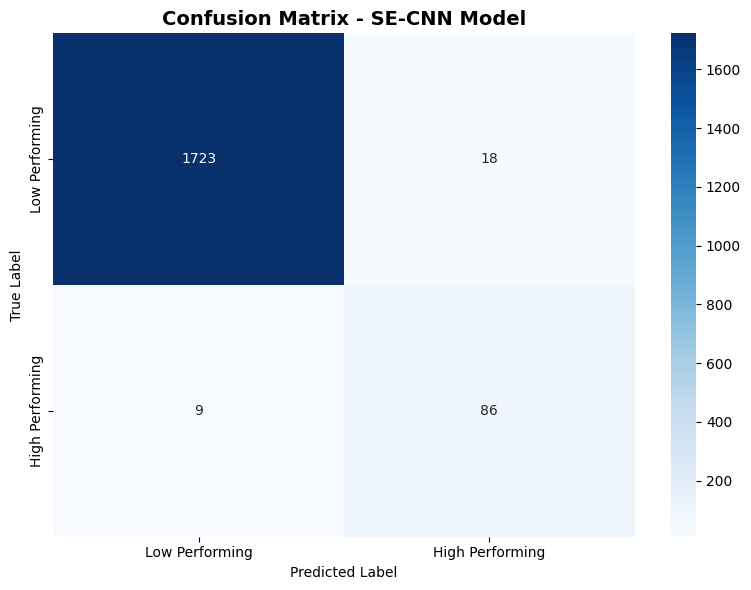

In [13]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Low Performing', 'High Performing'],
            yticklabels=['Low Performing', 'High Performing'])
plt.title('Confusion Matrix - SE-CNN Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()


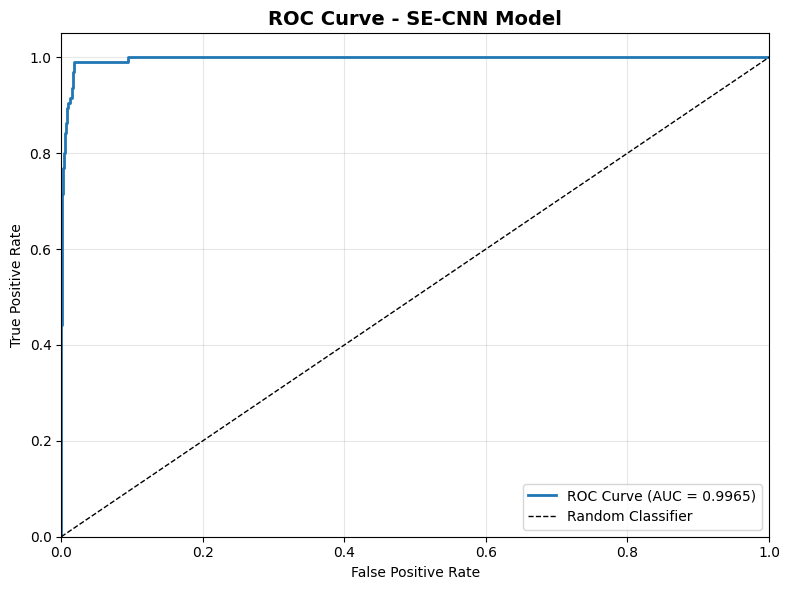

In [14]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test_class, y_probs)
auc = classification_metrics['auc']

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SE-CNN Model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'roc_curve.png'), dpi=300, bbox_inches='tight')
plt.show()


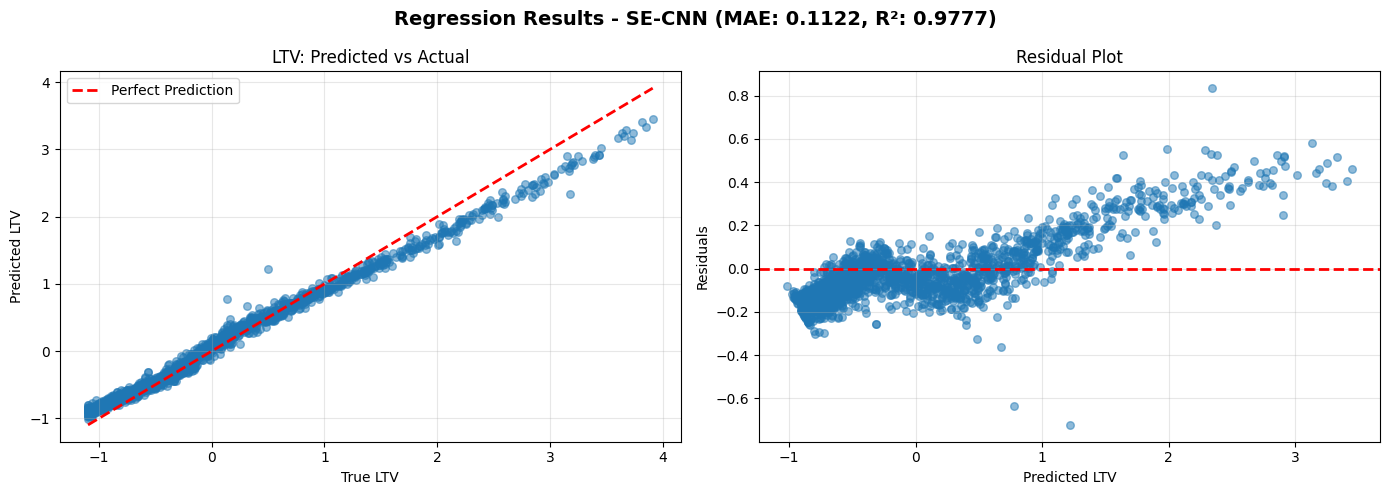

In [15]:
# Plot Regression Results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test_reg, y_pred_reg, alpha=0.5, s=30)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
             [y_test_reg.min(), y_test_reg.max()],
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('True LTV')
axes[0].set_ylabel('Predicted LTV')
axes[0].set_title('LTV: Predicted vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_test_reg - y_pred_reg
axes[1].scatter(y_pred_reg, residuals, alpha=0.5, s=30)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted LTV')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.suptitle(f'Regression Results - SE-CNN (MAE: {regression_metrics["mae"]:.4f}, R²: {regression_metrics["r2"]:.4f})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'regression_results.png'), dpi=300, bbox_inches='tight')
plt.show()



COMPARISON WITH BASELINE MODELS

               Model  Precision (%)  Recall (%)  Accuracy (%)      AUC
Logistic Regression      71.200000   68.900000     73.500000 0.781000
            XGBoost      75.900000   73.800000     77.400000 0.826000
                WDL      79.800000   78.400000     81.600000 0.857000
  SE-CNN (Proposed)      82.692308   90.526316     98.529412 0.996451



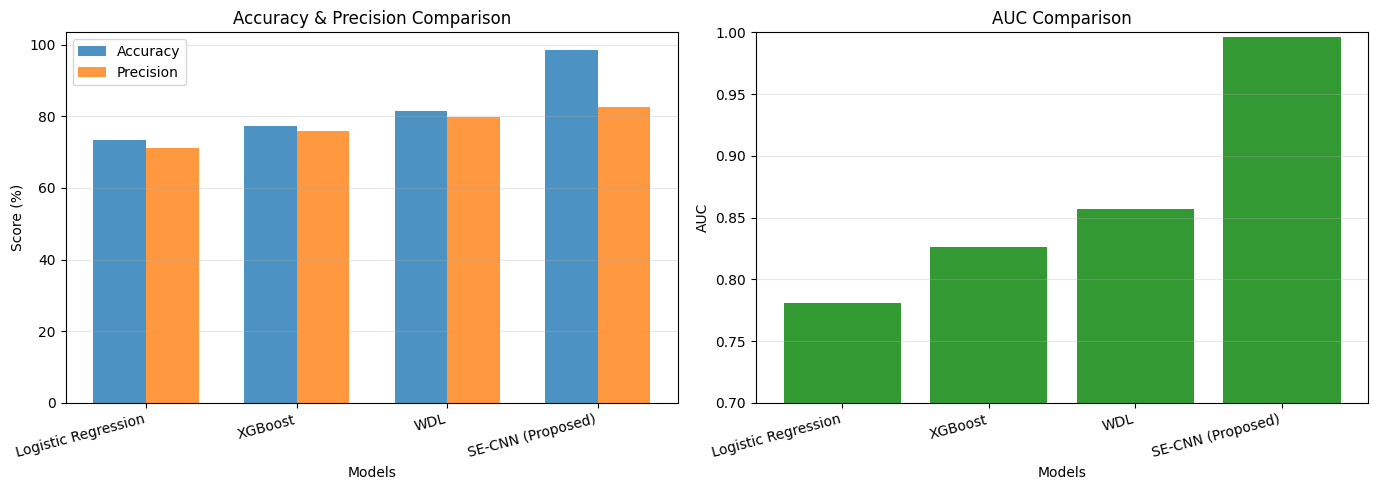

In [16]:
# Compare with Baseline Models
baseline_results = [
    {'Model': 'Logistic Regression', 'Precision (%)': 71.2, 'Recall (%)': 68.9, 'Accuracy (%)': 73.5, 'AUC': 0.781},
    {'Model': 'XGBoost', 'Precision (%)': 75.9, 'Recall (%)': 73.8, 'Accuracy (%)': 77.4, 'AUC': 0.826},
    {'Model': 'WDL', 'Precision (%)': 79.8, 'Recall (%)': 78.4, 'Accuracy (%)': 81.6, 'AUC': 0.857},
]

comparison_df = pd.DataFrame(baseline_results)

# Add SE-CNN results
se_cnn_results = {
    'Model': 'SE-CNN (Proposed)',
    'Precision (%)': classification_metrics['precision'] * 100,
    'Recall (%)': classification_metrics['recall'] * 100,
    'Accuracy (%)': classification_metrics['accuracy'] * 100,
    'AUC': classification_metrics['auc']
}
comparison_df = pd.concat([comparison_df, pd.DataFrame([se_cnn_results])], ignore_index=True)

print("\n" + "="*60)
print("COMPARISON WITH BASELINE MODELS")
print("="*60)
print("\n", comparison_df.to_string(index=False))
print("="*60 + "\n")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy and Precision
x = np.arange(len(comparison_df))
width = 0.35

axes[0].bar(x - width/2, comparison_df['Accuracy (%)'], width, label='Accuracy', alpha=0.8)
axes[0].bar(x + width/2, comparison_df['Precision (%)'], width, label='Precision', alpha=0.8)
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Score (%)')
axes[0].set_title('Accuracy & Precision Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# AUC
axes[1].bar(comparison_df['Model'], comparison_df['AUC'], alpha=0.8, color='green')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('AUC')
axes[1].set_title('AUC Comparison')
axes[1].set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0.7, 1.0])

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'baseline_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# Save comparison
comparison_df.to_csv(os.path.join(RESULTS_DIR, 'model_comparison.csv'), index=False)


In [17]:
# Step 5: Budget Optimization
print_banner("STEP 5: BUDGET OPTIMIZATION")

# Decode categorical features for optimization
test_df_opt = test_df.copy()
for col, encoder in preprocessor.label_encoders.items():
    if col in test_df_opt.columns:
        encoded_values = test_df_opt[col].values
        decoded_values = []
        for val in encoded_values:
            try:
                if val >= 0 and val < len(encoder.classes_):
                    decoded_values.append(encoder.classes_[val])
                else:
                    decoded_values.append('Unknown')
            except:
                decoded_values.append('Unknown')
        test_df_opt[col] = decoded_values

print("✓ Decoded categorical features to actual names")

# Add predictions to dataframe
test_df_opt['Predicted_Prob'] = predictions_dict['classification_probs']
test_df_opt['Predicted_LTV'] = predictions_dict['regression_values']

# Calculate expected value
test_df_opt['Expected_Value'] = (
    test_df_opt['Predicted_Prob'] *
    test_df_opt['ROI'] *
    test_df_opt['Predicted_LTV']
)

# Filter campaigns with positive expected value
test_df_opt = test_df_opt[test_df_opt['Expected_Value'] > 0].reset_index(drop=True)

print(f"\nCampaigns eligible for optimization: {len(test_df_opt)}")

# Budget Optimization using Linear Programming with two strategies
n_campaigns = len(test_df_opt)
allocation_strategy = None
optimal_budgets = None

# Strategy 1: Try full optimization with platform constraints
print("\n" + "="*60)
print("SOLVING BUDGET OPTIMIZATION PROBLEM")
print("="*60)
print("\nAttempt 1: Full optimization with platform constraints...")

try:
    prob_full = LpProblem("Marketing_Budget_Optimization", LpMaximize)

    # Decision variables with minimum budget
    budgets_full = {
        i: LpVariable(f"budget_{i}",
                     lowBound=MIN_BUDGET_PER_CAMPAIGN,
                     upBound=MAX_BUDGET_PER_CAMPAIGN)
        for i in range(n_campaigns)
    }

    # Objective: Maximize total expected value
    prob_full += lpSum([
        budgets_full[i] * test_df_opt.loc[i, 'Expected_Value']
        for i in range(n_campaigns)
    ]), "Total_Expected_Value"

    # Constraint 1: Total budget
    prob_full += lpSum([budgets_full[i] for i in range(n_campaigns)]) <= TOTAL_BUDGET, "Total_Budget_Constraint"

    # Constraint 2: Platform-wise budget constraints
    platforms = test_df_opt['Platform'].unique()
    platform_counts = test_df_opt['Platform'].value_counts()
    print(f"\nPlatform distribution: {platform_counts.to_dict()}")

    for platform in platforms:
        platform_indices = test_df_opt[test_df_opt['Platform'] == platform].index.tolist()

        if platform in PLATFORM_BUDGET_CONSTRAINTS and len(platform_indices) > 0:
            min_pct, max_pct = PLATFORM_BUDGET_CONSTRAINTS[platform]

            # Check if constraints are feasible
            min_required = min_pct * TOTAL_BUDGET
            max_allowed = max_pct * TOTAL_BUDGET
            min_possible = len(platform_indices) * MIN_BUDGET_PER_CAMPAIGN
            max_possible = len(platform_indices) * MAX_BUDGET_PER_CAMPAIGN

            # Only add constraint if feasible
            if min_required <= max_possible and max_allowed >= min_possible:
                prob_full += (
                    lpSum([budgets_full[i] for i in platform_indices]) >= min_required
                ), f"{platform}_Min_Budget"

                prob_full += (
                    lpSum([budgets_full[i] for i in platform_indices]) <= max_allowed
                ), f"{platform}_Max_Budget"
            else:
                print(f"Skipping infeasible constraints for {platform}")

    # Solve
    prob_full.solve()

    if LpStatus[prob_full.status] == 'Optimal':
        print("✓ Full optimization successful!")
        optimal_budgets = [pulp.value(budgets_full[i]) for i in range(n_campaigns)]
        allocation_strategy = 'constraint'
    else:
        print(f"Full optimization status: {LpStatus[prob_full.status]}")
        raise Exception("Full optimization not optimal")

except Exception as e:
    print(f"Full optimization failed: {str(e)}")

    # Strategy 2: Try relaxed optimization (no platform constraints)
    print("\nAttempting optimization with relaxed constraints...")
    try:
        prob_relaxed = LpProblem("Marketing_Budget_Optimization_Relaxed", LpMaximize)

        # Decision variables with relaxed bounds (allow zero)
        budgets_relaxed = {
            i: LpVariable(f"budget_{i}",
                         lowBound=0,
                         upBound=MAX_BUDGET_PER_CAMPAIGN)
            for i in range(n_campaigns)
        }

        # Objective: Maximize total expected value
        prob_relaxed += lpSum([
            budgets_relaxed[i] * test_df_opt.loc[i, 'Expected_Value']
            for i in range(n_campaigns)
        ]), "Total_Expected_Value"

        # Only constraint: Total budget limit
        prob_relaxed += lpSum([budgets_relaxed[i] for i in range(n_campaigns)]) <= TOTAL_BUDGET, "Total_Budget_Constraint"

        # Solve
        prob_relaxed.solve()

        if LpStatus[prob_relaxed.status] == 'Optimal':
            print("✓ Relaxed optimization successful!")
            optimal_budgets = [pulp.value(budgets_relaxed[i]) for i in range(n_campaigns)]
            allocation_strategy = 'flexible'
        else:
            print(f"Relaxed optimization status: {LpStatus[prob_relaxed.status]}")
            optimal_budgets = None
    except Exception as e2:
        print(f"Relaxed optimization failed: {str(e2)}")
        optimal_budgets = None

# Apply results
if optimal_budgets is not None:
    test_df_opt['Optimal_Budget'] = optimal_budgets

    # Filter out zero-budget campaigns
    test_df_opt = test_df_opt[test_df_opt['Optimal_Budget'] > 0].reset_index(drop=True)

    # Calculate metrics
    total_allocated = test_df_opt['Optimal_Budget'].sum()
    total_expected_roi = (test_df_opt['Optimal_Budget'] * test_df_opt['Expected_Value']).sum()
    budget_utilization = (total_allocated / TOTAL_BUDGET) * 100

    print(f"\nTotal Budget Allocated: ${total_allocated:,.2f}")
    print(f"Budget Utilization: {budget_utilization:.2f}%")
    print(f"Expected Total ROI: {total_expected_roi:,.2f}")
    print(f"Campaigns Funded: {len(test_df_opt)}")
    print(f"Allocation Strategy: {allocation_strategy}")
    print("="*60 + "\n")
else:
    print("\nNo feasible budget allocation found using constraint or flexible strategies.")
    test_df_opt['Optimal_Budget'] = 0



                          STEP 5: BUDGET OPTIMIZATION                           

✓ Decoded categorical features to actual names

Campaigns eligible for optimization: 999

SOLVING BUDGET OPTIMIZATION PROBLEM

Attempt 1: Full optimization with platform constraints...

Platform distribution: {'Google': 470, 'Meta': 349, 'LinkedIn': 64, 'Twitter': 61, 'TikTok': 55}
✓ Full optimization successful!

Total Budget Allocated: $200,000.00
Budget Utilization: 100.00%
Expected Total ROI: 164,803.11
Campaigns Funded: 999
Allocation Strategy: constraint



In [18]:
# Budget Allocation Analysis
if optimal_budgets is not None and len(test_df_opt[test_df_opt['Optimal_Budget'] > 0]) > 0:
    print("\n" + "="*60)
    print("BUDGET ALLOCATION ANALYSIS")
    print("="*60)

    # Platform-wise allocation
    print("\n--- Platform-wise Budget Allocation ---")
    platform_allocation = test_df_opt.groupby('Platform')['Optimal_Budget'].agg(['sum', 'count', 'mean'])
    platform_allocation['percentage'] = (platform_allocation['sum'] / total_allocated) * 100
    platform_allocation.columns = ['Total Budget ($)', 'Campaigns', 'Avg Budget ($)', 'Percentage (%)']
    print(platform_allocation.to_string())

    # Country-wise allocation (Top 10)
    print("\n--- Country-wise Budget Allocation (Top 10) ---")
    country_allocation = test_df_opt.groupby('Country')['Optimal_Budget'].agg(['sum', 'count', 'mean'])
    country_allocation['percentage'] = (country_allocation['sum'] / total_allocated) * 100
    country_allocation.columns = ['Total Budget ($)', 'Campaigns', 'Avg Budget ($)', 'Percentage (%)']
    country_allocation = country_allocation.sort_values('Total Budget ($)', ascending=False).head(10)
    print(country_allocation.to_string())

    # Performance-based allocation
    print("\n--- High vs Low Performing Campaigns ---")
    perf_allocation = test_df_opt.groupby(CLASSIFICATION_TARGET)['Optimal_Budget'].agg(['sum', 'count', 'mean'])
    perf_allocation['percentage'] = (perf_allocation['sum'] / total_allocated) * 100
    perf_allocation.columns = ['Total Budget ($)', 'Campaigns', 'Avg Budget ($)', 'Percentage (%)']
    perf_allocation.index = ['Low Performing', 'High Performing']
    print(perf_allocation.to_string())

    print("="*60 + "\n")



BUDGET ALLOCATION ANALYSIS

--- Platform-wise Budget Allocation ---
          Total Budget ($)  Campaigns  Avg Budget ($)  Percentage (%)
Platform                                                             
Google             96900.0        470      206.170213           48.45
LinkedIn           20000.0         64      312.500000           10.00
Meta               43100.0        349      123.495702           21.55
TikTok             20000.0         55      363.636364           10.00
Twitter            20000.0         61      327.868852           10.00

--- Country-wise Budget Allocation (Top 10) ---
           Total Budget ($)  Campaigns  Avg Budget ($)  Percentage (%)
Country                                                               
USA                 73800.0        103      716.504854           36.90
UAE                 24300.0         98      247.959184           12.15
India               23300.0         94      247.872340           11.65
Germany             18000.0         9

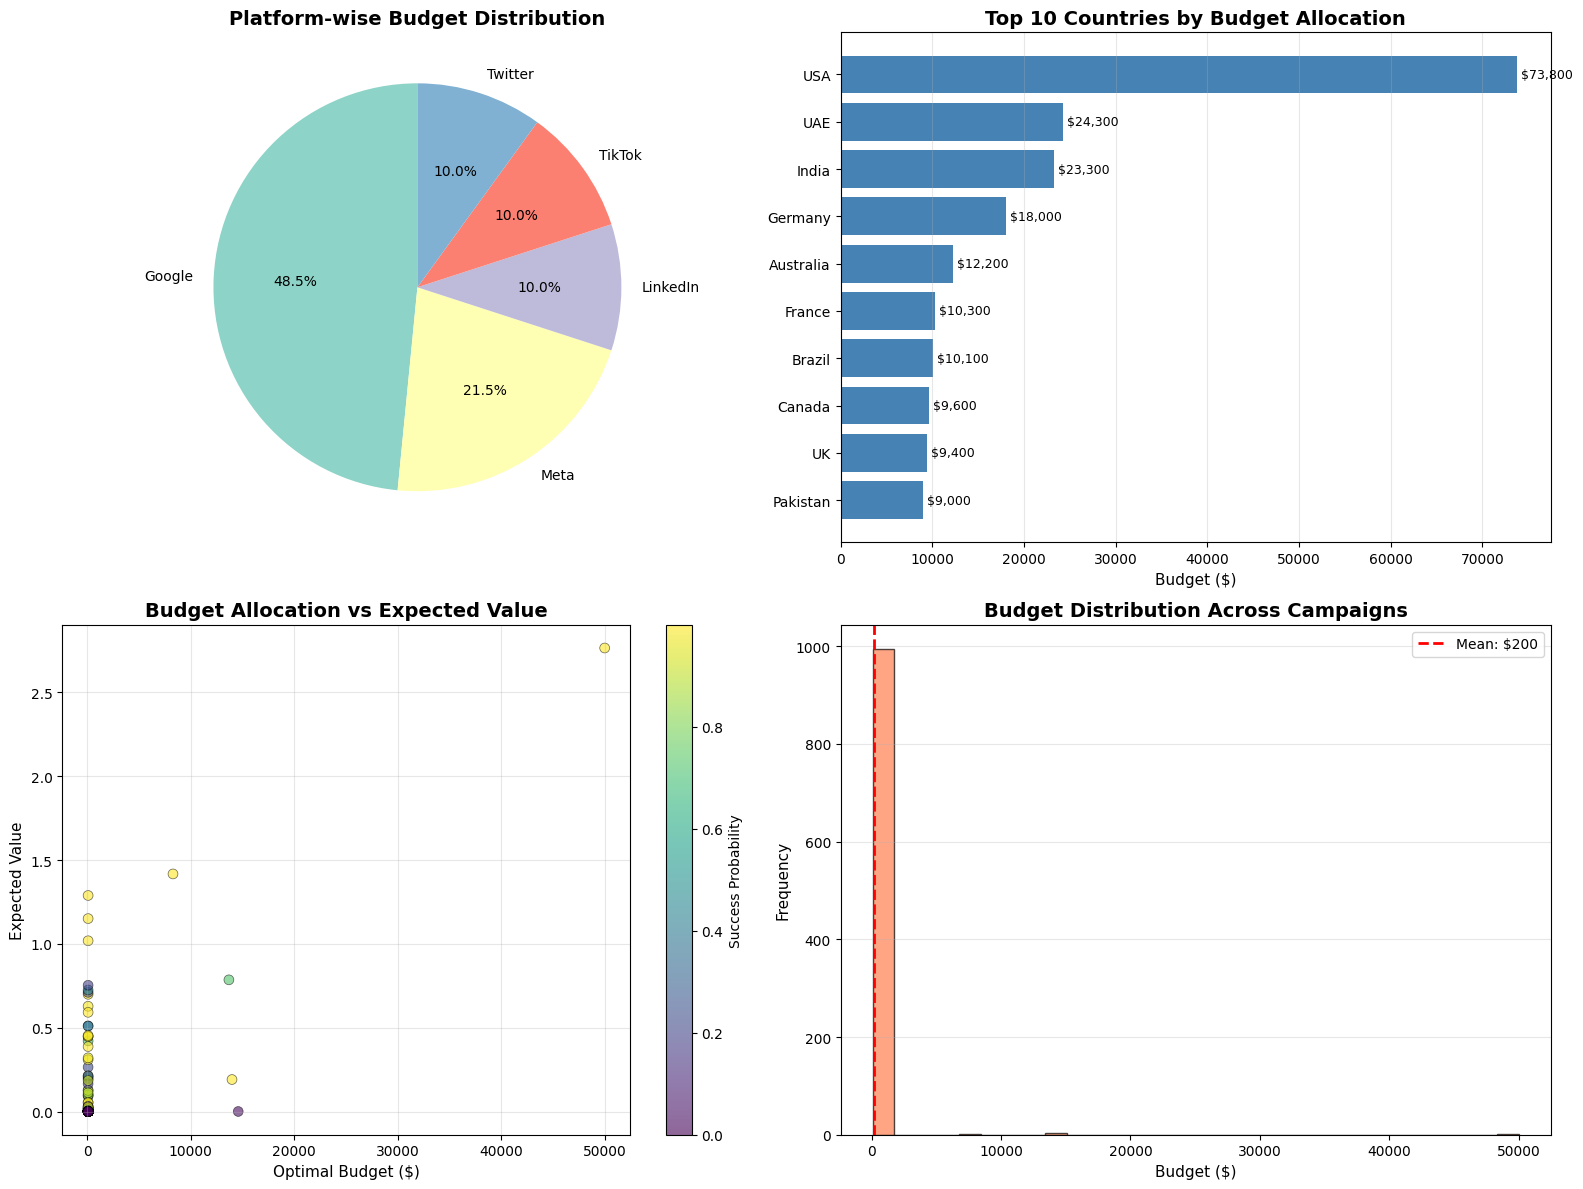

Allocation plots saved to /content/results/budget_allocation.png


In [19]:
# Visualize Budget Allocation
if optimal_budgets is not None and len(test_df_opt[test_df_opt['Optimal_Budget'] > 0]) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Platform allocation (pie chart)
    platform_data = test_df_opt.groupby('Platform')['Optimal_Budget'].sum().sort_values(ascending=False)
    colors = sns.color_palette('Set3', len(platform_data))
    axes[0, 0].pie(platform_data.values, labels=platform_data.index, autopct='%1.1f%%',
                   startangle=90, colors=colors)
    axes[0, 0].set_title('Platform-wise Budget Distribution', fontweight='bold', fontsize=14)

    # Country allocation (top 10 bar chart)
    country_data = test_df_opt.groupby('Country')['Optimal_Budget'].sum().sort_values(ascending=False).head(10)
    axes[0, 1].barh(range(len(country_data)), country_data.values, color='steelblue')
    axes[0, 1].set_yticks(range(len(country_data)))
    axes[0, 1].set_yticklabels(country_data.index, fontsize=10)
    axes[0, 1].set_xlabel('Budget ($)', fontsize=11)
    axes[0, 1].set_title('Top 10 Countries by Budget Allocation', fontweight='bold', fontsize=14)
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x', alpha=0.3)

    # Add value labels
    for i, v in enumerate(country_data.values):
        axes[0, 1].text(v, i, f' ${v:,.0f}', va='center', fontsize=9)

    # Budget vs Expected Value (scatter)
    scatter = axes[1, 0].scatter(test_df_opt['Optimal_Budget'],
                      test_df_opt['Expected_Value'],
                      alpha=0.6, s=50, c=test_df_opt['Predicted_Prob'],
                      cmap='viridis', edgecolors='black', linewidth=0.5)
    axes[1, 0].set_xlabel('Optimal Budget ($)', fontsize=11)
    axes[1, 0].set_ylabel('Expected Value', fontsize=11)
    axes[1, 0].set_title('Budget Allocation vs Expected Value', fontweight='bold', fontsize=14)
    axes[1, 0].grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=axes[1, 0])
    cbar.set_label('Success Probability', fontsize=10)

    # Budget distribution (histogram)
    axes[1, 1].hist(test_df_opt['Optimal_Budget'], bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Budget ($)', fontsize=11)
    axes[1, 1].set_ylabel('Frequency', fontsize=11)
    axes[1, 1].set_title('Budget Distribution Across Campaigns', fontweight='bold', fontsize=14)
    mean_budget = test_df_opt['Optimal_Budget'].mean()
    axes[1, 1].axvline(mean_budget, color='red',
                      linestyle='--', linewidth=2, label=f"Mean: ${mean_budget:,.0f}")
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'budget_allocation.png'), dpi=300, bbox_inches='tight')
    plt.show()

    print(f"Allocation plots saved to {os.path.join(RESULTS_DIR, 'budget_allocation.png')}")


In [20]:
# Export Budget Recommendations
if optimal_budgets is not None and len(test_df_opt[test_df_opt['Optimal_Budget'] > 0]) > 0:
    # Select relevant columns for export
    export_cols = ['Ad_ID', 'Campaign_ID', 'Campaign_Name', 'Platform', 'Country',
                   'CPC_USD', 'CTR', 'ROI', 'Predicted_Prob', 'Predicted_LTV',
                   'Expected_Value', 'Optimal_Budget', CLASSIFICATION_TARGET]

    # Only include columns that exist
    export_cols = [col for col in export_cols if col in test_df_opt.columns]

    export_df = test_df_opt[export_cols].sort_values('Optimal_Budget', ascending=False)
    export_path = os.path.join(RESULTS_DIR, 'budget_recommendations.csv')
    export_df.to_csv(export_path, index=False)

    print(f"\nBudget recommendations exported to {export_path}")
    print(f"\nTop 10 Budget Recommendations:")
    print(export_df.head(10).to_string(index=False))



Budget recommendations exported to /content/results/budget_recommendations.csv

Top 10 Budget Recommendations:
                               Ad_ID Campaign_ID Campaign_Name Platform Country   CPC_USD       CTR       ROI  Predicted_Prob  Predicted_LTV  Expected_Value  Optimal_Budget  High_Performing_Label
fc164e12-0f2c-4e72-acad-8471715d0d29    CMP10249  Campaign_249   Google     USA -0.967893  2.616377  4.221124    9.976639e-01       0.656425    2.764378e+00         50000.0                      1
ccad6bdb-17bf-493e-a7c0-0fb6d1da4aef    CMP10331  Campaign_331   TikTok     UAE -0.596993  0.443861  0.028759    3.018829e-02       0.467890    4.062211e-04         14600.0                      0
8bf0f36b-ca27-49ec-aa1c-9129e18a38f1    CMP10325  Campaign_325  Twitter   India -1.123832  1.881150  0.545958    9.976273e-01       0.350571    1.909427e-01         14000.0                      1
9bd05cc7-9c1e-4512-9a1d-401e92340be0    CMP10261  Campaign_261 LinkedIn     USA -0.700279  2.986263  1.5

In [21]:
# Generate Summary Report
print_banner("SUMMARY REPORT")

report_path = os.path.join(RESULTS_DIR, 'summary_report.txt')

with open(report_path, 'w') as f:
    f.write("="*80 + "\n")
    f.write("SE-CNN-BASED MARKETING OPTIMIZATION - SUMMARY REPORT\n")
    f.write("="*80 + "\n\n")

    f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model Type: SE-CNN (Squeeze-and-Excitation CNN)\n\n")

    f.write("-" * 80 + "\n")
    f.write("TRAINING RESULTS\n")
    f.write("-" * 80 + "\n")
    f.write(f"Final Train Loss: {history_dict['loss'][-1]:.4f}\n")
    f.write(f"Final Val Loss: {history_dict['val_loss'][-1]:.4f}\n")
    f.write(f"Final Train Accuracy: {history_dict['classification_output_accuracy'][-1]:.4f}\n")
    f.write(f"Final Val Accuracy: {history_dict['val_classification_output_accuracy'][-1]:.4f}\n")
    f.write(f"Best Epoch: {np.argmin(history_dict['val_loss']) + 1}\n")
    f.write(f"Total Epochs: {len(history_dict['loss'])}\n\n")

    f.write("-" * 80 + "\n")
    f.write("EVALUATION RESULTS\n")
    f.write("-" * 80 + "\n")
    f.write("\nClassification Metrics:\n")
    for key, value in classification_metrics.items():
        f.write(f"  {key}: {value:.4f}\n")

    f.write("\nRegression Metrics:\n")
    for key, value in regression_metrics.items():
        f.write(f"  {key}: {value:.4f}\n")
    f.write("\n")

    f.write("-" * 80 + "\n")
    f.write("OPTIMIZATION RESULTS\n")
    f.write("-" * 80 + "\n")
    if optimal_budgets is not None and len(test_df_opt[test_df_opt['Optimal_Budget'] > 0]) > 0:
        f.write(f"Total Budget Allocated: ${total_allocated:,.2f}\n")
        f.write(f"Budget Utilization: {budget_utilization:.2f}%\n")
        f.write(f"Expected Total ROI: {total_expected_roi:,.2f}\n")
        f.write(f"Campaigns Funded: {len(test_df_opt[test_df_opt['Optimal_Budget'] > 0])}\n")
    else:
        f.write("Budget optimization was not successful.\n")

    f.write("\n" + "="*80 + "\n")
    f.write("END OF REPORT\n")
    f.write("="*80 + "\n")

# Print report
with open(report_path, 'r') as f:
    print("\n" + f.read())

print(f"\nSummary report saved to {report_path}")



                                 SUMMARY REPORT                                 


SE-CNN-BASED MARKETING OPTIMIZATION - SUMMARY REPORT

Generated: 2025-11-28 06:56:08
Model Type: SE-CNN (Squeeze-and-Excitation CNN)

--------------------------------------------------------------------------------
TRAINING RESULTS
--------------------------------------------------------------------------------
Final Train Loss: 0.0196
Final Val Loss: 0.0383
Final Train Accuracy: 0.9954
Final Val Accuracy: 0.9793
Best Epoch: 12
Total Epochs: 20

--------------------------------------------------------------------------------
EVALUATION RESULTS
--------------------------------------------------------------------------------

Classification Metrics:
  accuracy: 0.9853
  precision: 0.8269
  recall: 0.9053
  f1_score: 0.8643
  auc: 0.9965

Regression Metrics:
  mae: 0.1122
  rmse: 0.1482
  r2: 0.9777

--------------------------------------------------------------------------------
OPTIMIZATION RESULTS
-----

## Results Summary

All results have been generated and saved:

1. **Model**: Saved to `/content/models/se_cnn_marketing_model.h5`
2. **Training History Plot**: `/content/results/training_history.png`
3. **Confusion Matrix**: `/content/results/confusion_matrix.png`
4. **ROC Curve**: `/content/results/roc_curve.png`
5. **Regression Results**: `/content/results/regression_results.png`
6. **Baseline Comparison**: `/content/results/baseline_comparison.png`
7. **Budget Allocation**: `/content/results/budget_allocation.png`
8. **Budget Recommendations**: `/content/results/budget_recommendations.csv`
9. **Model Comparison**: `/content/results/model_comparison.csv`
10. **Summary Report**: `/content/results/summary_report.txt`

